In [1]:
import numpy as np
from scipy.optimize import minimize

from astropy.cosmology import LambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import quantity_support
quantity_support()

import matplotlib.pyplot as plt

# Plotting info from TOPCAT 

## Number of matches vs. matching radius

I got the data below via TOPCAT's table-matching feature. I selected "Best match, symmetric" and "1 and 2" for Match Selection and Join Type, respectively. Then, I plugged in different matching radii using the Max error option.

In [2]:
## Plotting number of matches vs. match radius
# match_radius = [.1, .2, .3, .4, .5, \
#                 .6, .7, .8, .9, 1, \
#                1.1, 1.2, 1.3, 1.4, 1.5, \
#                2, 2.5, 3, 4, 5, 6, 7, \
#                10, 15] # arcmin
# num_matches = [6, 34, 48, 71, 94, \
#                107, 123, 142, 149, 157, \
#               162, 167, 170, 175, 178,
#               187, 190, 194, 201, 205, 210, 215, \
#               234, 247]

# plt.scatter(match_radius, num_matches)
# plt.xlabel('Matching radius (arcminutes)')
# plt.ylabel('Number of matches')

# plt.show()

# Load in cluster catalogs

## ACT catalog

In [3]:
# # open the catalog directly
# ACT_cat = fits.open('DR5_cluster-catalog_v1.1.fits')
# ACT_cat.info()
# ACT_cat.close()

# # open the catalog with context manger
# with fits.open('DR5_cluster-catalog_v1.1.fits') as hdul:
#     catalog = hdul[1].data
#     print('cluster names (length = 4195):')
#     print(catalog.field('name'))

Reading tables in FITS format: https://docs.astropy.org/en/stable/io/unified.html#fits

In [4]:
ACT_cat = Table.read('DR5_cluster-catalog_v1.1.fits', hdu = 1)

column = np.asarray(ACT_cat['decDeg'])
print(f'There are {len(column)} ACT clusters.')

There are 4195 ACT clusters.


## HSC catalog
Each row has 6 values: RA (degrees), Dec (degrees), z_cl, N_mem, logMs, and z_bcg; in that order. z_bcg = -1.0 indicates that the cluster has no identified BCG.

HSC_cat omits the last column of the data file, which lists the ID of a cluster.

In [5]:
HSC_cat_orig = np.loadtxt('camira_s19a_wide_v1.txt', # HSC catalog (sm = star mask)
                     usecols=(0,1,2,3,4,5)) 

# filter out low-richness clusters
good_richness = HSC_cat_orig[:,3] > 15
HSC_cat = HSC_cat_orig[good_richness]

print(f'There are {HSC_cat.shape[0]} HSC clusters.')

There are 6932 HSC clusters.


## Create SkyCoords

In [6]:
## SkyCoord objects for ACT and HSC
ACT_coords = SkyCoord(ra=ACT_cat['RADeg'] * u.degree, 
                      dec=ACT_cat['decDeg'] * u.degree, 
                      frame='icrs')
HSC_coords = SkyCoord(ra=HSC_cat[:,0] * u.degree, 
                      dec=HSC_cat[:,1] * u.degree, 
                      frame='icrs')

# convert coords to (-pi, pi) radians
act_ra = ACT_coords.ra.wrap_at(180 * u.deg).radian
act_dec = ACT_coords.dec.radian
hsc_ra = HSC_coords.ra.wrap_at(180 * u.deg).radian
hsc_dec = HSC_coords.dec.radian

## Print catalog properties

In [ ]:
## Some ACT catalog properties

in_hsc_footprint = ACT_cat['footprint_HSCs19a']
print('Number of ACT clusters in HSC footprint: ' + 
      str(np.sum(in_hsc_footprint)))

has_hsc_counterpart = ACT_cat['CAMIRA']
print('Number of ACT clusters cross-matched with CAMIRA: ' + 
      str(np.sum(has_hsc_counterpart)))


position_from_cam = (ACT_cat['opt_positionSource'] == 'CAMIRA')
print('Number of ACT clusters with positions from CAMIRA: ' + 
      str(np.sum(position_from_cam)))

print()

print('Number of ACT clusters in SDSS footprint: ' + 
      'N/A')

has_sdss_counterpart = ACT_cat['RM'] 
print('Number of ACT clusters cross-matched with RM (SDSS): ' + 
      str(np.sum(has_sdss_counterpart)))

position_from_sdss = (ACT_cat['opt_positionSource'] == 'RM')
print('Number of ACT clusters with positions from RM (SDSS): ' + 
      str(np.sum(position_from_sdss)))

print() 

in_des_footprint = ACT_cat['footprint_DESY3']
print('Number of ACT clusters in DES footprint: ' + 
      str(np.sum(in_des_footprint)))

has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with RM (DES): ' + 
      str(np.sum(has_des_counterpart)))

position_from_des = (ACT_cat['opt_positionSource'] == 'RMDESY3') | \
                    (ACT_cat['opt_positionSource'] == 'RMDESY3ACT')
print('Number of ACT clusters with positions from RM (DES): ' + 
      str(np.sum(position_from_des)))

# Plot centering offsets (ACT-HSC)

In [8]:
def get_physical_sep(cosmo, theta, z):
    '''
    
    For two objects at the same redshift, calculate their physical separation 
    R as R = theta * d_A, where theta is angular separation (in radians) and 
    d_A is angular distance.
    
    ARGUMENTS
    ----------
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    theta: angular separation; should be a Quantity 
    z: redshift
    
    '''
    
    theta = theta.to(u.rad) / u.rad
    return theta * cosmo.angular_diameter_distance(z)

Note: Let $d_p$ be proper distance. Since $d_p \propto c/H_0$, $d_p$ as a function of $h$ (using $h \equiv \frac{H_0}{100 \text{ km/s/Mpc}}$) is $d_p(h) = h^{-1} d_p(h=1)$.

In [67]:
## Testing get_physical_sep

# h = 0.7
# temp_cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
# # temp_angle = 3 * u.arcmin
# # temp_z = 1
# # get_physical_sep(temp_cosmo, temp_angle, temp_z)

# theta_grid = np.linspace(0, 6, 50) * u.arcmin
# temp_offsets = get_physical_sep(temp_cosmo, theta_grid, z=0.3)

# fig = plt.figure(figsize=(10,7))
# plt.plot(theta_grid, temp_offsets, label='fixed z')
# plt.plot(theta_grid, np.ones(50) / h, label='offset=1 Mpc/h')
# plt.xlabel('Angle (arcminutes)')

# plt.legend()
# plt.show()

In [68]:
## Plot physical offset as a function of (theta, z)

# theta_grid = np.linspace(0., 5, 50)
# z_grid = np.linspace(0, 1.4, 50)
# theta_grid,z_grid = np.meshgrid(theta_grid, z_grid)
# theta_grid *= u.arcmin

# temp_offsets = get_physical_sep(temp_cosmo, theta_grid.ravel(), z_grid.ravel())
# temp_offsets = temp_offsets.reshape(theta_grid.shape)

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X=theta_grid, Y=z_grid, Z=temp_offsets, label="Offsets")
# ax.plot_surface(X=theta_grid, Y=z_grid, Z=np.ones(temp_offsets.shape) / h, \
#                 label="Offset = 1 Mpc / h")
# ax.set_xlabel('theta (arcmin)')
# ax.set_ylabel('redshift')
# ax.set_zlabel('physical offset (Mpc)')

# plt.show()

# Modeling the offset distribution

See CAMIRA paper, equation 9.

In [9]:
from scipy.stats import norm

def offset_model(offset, f_cen, sigma_1, sigma_2):
    '''
    
    A two-component Gaussian model for the centering offsets distribution.
    Returns the probability density at a given offset.
    (offset, sigma_1, and sigma_2 have units of Mpc.)
    
    ARGUMENTS
    ----------
    offset: centering offset
    f_cen: fraction of well-centered clusters
    sigma_1: standard deviation for the well-centered cluster population
    sigma_2: standard deviation for the miscentered cluster population
    
    '''
    
    return f_cen * (offset / sigma_1**2) * norm.pdf(offset, loc=0, scale=sigma_1) + \
        (1 - f_cen) * (offset / sigma_2**2) * norm.pdf(offset, loc=0, scale=sigma_2)

def objective_fn(params, offsets):
    '''
    
    Given the model parameters and the set of offsets, compute
    the objective as follows: if P_i is the prob. density for
    offset i, then the objective is the inverse of all the P_i's 
    multiplied together.
    
    ARGUMENTS
    ----------
    params: tunable parameters in offset_model
    offsets: set of physical offsets (Mpc; same as offset_model)
    
    '''
    
    f_cen, sigma_1, sigma_2 = params
    probs = offset_model(offsets, f_cen, sigma_1, sigma_2)
    obj = 1 / np.product(probs)
    if obj > 1e200:
        print("Warning: objective is over 1e200; check that your input offsets are realistic.")
    
    return obj

## Using the "has_cam_opt_coords" flag

There are 61 ACT clusters that are flagged as having their optical position coming from CAMIRA, and 56 of them have valid optical positions in the catalog. (The other 5 were probably added after using CAMIRA in scanning mode; i.e. they weren't originally in the catalog, but were added based on ACT information.)

The well-centered fraction is low (~30%). Since these clusters are outside of the DES footprint (and because properties shouldn't depend on location), this likely isn't due to a selection effect.

In [37]:
# Create optical and SZ position catalogs

has_cam_opt_coords = position_from_cam & (ACT_cat['opt_RADeg'] != -99)
cam_ra = ACT_cat['opt_RADeg'][has_cam_opt_coords]
cam_dec = ACT_cat['opt_decDeg'][has_cam_opt_coords]

cam_opt = SkyCoord(ra=cam_ra * u.degree, 
                      dec=cam_dec * u.degree, 
                      frame='icrs')
cam_sz = ACT_coords[has_cam_opt_coords]

# Calculate physical offsets
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
angular_sep = cam_opt.separation(cam_sz)
redshifts = ACT_cat[has_cam_opt_coords]['redshift']
physical_sep = get_physical_sep(cosmo, angular_sep, redshifts)

# plt.figure(figsize=(10,5))
# plt.title(f"ACT-CAMIRA offset distribution (has_cam_opt_coords; n = {len(physical_sep)})")
# bins = np.linspace(0, np.max(physical_sep), num=15)
# plt.hist(physical_sep, bins=bins)
# plt.xlabel("Offset (Mpc)")
# plt.ylabel("Number of clusters")

# plt.show()

In [38]:
## Optimize (has_cam_opt_coords)
x = np.zeros(50) + 0.2
x = np.append(x, 1)
x2 = np.append(x, x)

offsets = physical_sep.value

initial_guess = (0.68, 0.07, 0.37)
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(offsets), \
                     method='Nelder-Mead')

init_obj = objective_fn(initial_guess, offsets)
print(f'Initial obj: {init_obj}\n')

f_best, sig1_best, sig2_best = best_guess.x
print(best_guess)

Initial obj: 8.494371247281565e-26

 final_simplex: (array([[0.30017535, 0.04660083, 0.22713146],
       [0.30012474, 0.04659804, 0.22712335],
       [0.30016712, 0.04658852, 0.227147  ],
       [0.30026061, 0.04659352, 0.22713488]]), array([2.92188673e-32, 2.92188800e-32, 2.92189030e-32, 2.92189031e-32]))
           fun: 2.921886731524082e-32
       message: 'Optimization terminated successfully.'
          nfev: 178
           nit: 100
        status: 0
       success: True
             x: array([0.30017535, 0.04660083, 0.22713146])


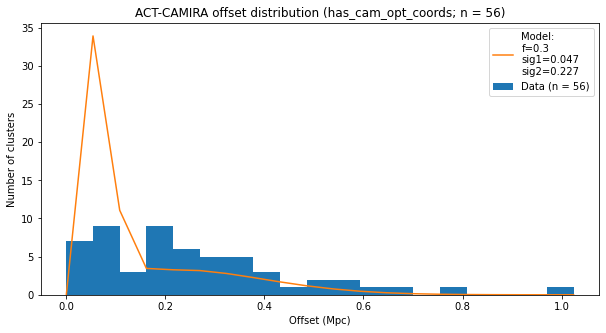

In [41]:
## Plot offset distro (has_cam_opt_coords)

plt.figure(figsize=(10,5))

plt.title(f"ACT-CAMIRA offset distribution (has_cam_opt_coords; n = {len(physical_sep)})")

# Data
num_bins = 20
bins = np.linspace(0, np.max(physical_sep), num=num_bins)
plt.hist(physical_sep, bins=bins, label=f"Data (n = {len(physical_sep)})")
plt.xlabel("Offset (Mpc)")
plt.ylabel("Number of clusters")

# Model
x_axis = np.linspace(0, np.max(physical_sep), num=num_bins)
y_axis = offset_model(offset=x_axis, f_cen=f_best, sigma_1=sig1_best, sigma_2=sig2_best)
plt.plot(x_axis, y_axis, label=\
         f"Model:\nf={np.round(f_best,3)}\nsig1={np.round(sig1_best,3)}\nsig2={np.round(sig2_best,3)}")

plt.legend()
plt.show()

Check if the clusters with CAMIRA optical positions still in the DES and/or SDSS footprint.

In [29]:
np.sum(ACT_cat[has_cam_opt_coords]['footprint_DESY3'])

0

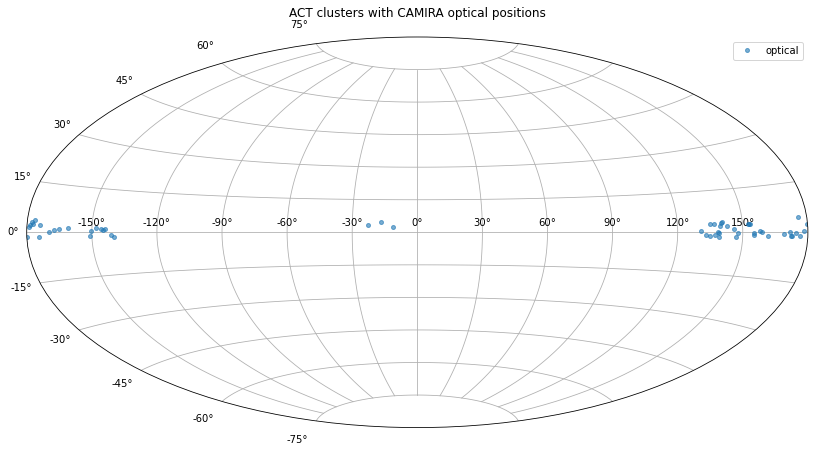

In [31]:
# convert coords to (-pi, pi) radians
cam_ra = cam_opt.ra.wrap_at(180 * u.deg).radian
cam_dec = cam_opt.dec.radian

plt.figure(figsize=(14,9))

plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.plot(cam_ra, cam_dec, 'o', markersize=4, alpha=0.6, label='optical')

plt.title("ACT clusters with CAMIRA optical positions", pad=20)
plt.legend()
plt.show()

# Cross-matching HSC and ACT clusters

The ACT catalog flags 212 ACT clusters as having a cross-match with HSC (via CAMIRA). Here, we get their CAMIRA positions.

In [10]:
def get_good_inds(idx, d2d, d3d):
    '''
    This function aims to remove duplicates from the results of an 
    asymmetric cross-match.
    
    Given idx, d2d, and d3d from astropy's match_to_catalog_sky function,
    return the 'good' indices in idx as a boolean array. (Here, bad means
    that an index in idx is matched to an object that already has a better 
    match in idx.)
    
    For example: if idx = (8, 8, 8) and d2d = (0.1, 0.3, 0.04), then we 
    accept the third element in idx and reject the two others. This 
    function then returns (False, False, True). 
    
    ARGUMENTS
    ---------
    idx, d2d, d3d: returns of astropy's match_to_catalog_sky function
    
    '''
    
    unique_idx, counts = np.unique(idx, return_counts=True)
    repeated_idxs = unique_idx[np.where(counts > 1)] # idxs appearing in idx multiple times
    good_ind = np.ones(idx.shape)
        
    for rep_idx in repeated_idxs:
        locs = np.where(idx == rep_idx)[0] # rep_idx's locations in idx
        best_loc = locs[0]
        
        for loc in locs:
            if d2d[loc] < d2d[best_loc]: best_loc = loc
        for loc in locs:        
            if loc != best_loc: good_ind[loc] = 0
    
    return good_ind == 1

In [11]:
# Note: idx indexes into HSC_coords
idx, d2d, d3d = ACT_coords[has_hsc_counterpart].match_to_catalog_sky(HSC_coords)
good_inds = get_good_inds(idx, d2d, d3d)

print(f'Number of ACT clusters flagged as having a match with HSC: {len(HSC_coords[idx])}')
print(f'Number of ACT clusters with an accepted match in HSC: {np.sum(good_inds)}')

Number of ACT clusters flagged as having a match with HSC: 212
Number of ACT clusters with an accepted match in HSC: 210


In [12]:
# Check for duplicates; ie, multiple ACT clusters being matched to the same HSC one
unique_idx, counts = np.unique(idx, return_counts=True)
np.where(counts > 1)

(array([ 85, 204]),)

In [42]:
## Verifying that get_good_inds works

#inds = slice(85, 87)
#inds = slice(193, 196)
#inds = slice(197, 199)
inds = slice(205, 207)
print(f'slice in idx: {idx[inds]}')
print(f'corresponding slice in d2d: {d2d[inds]}')
print(f'corresponding slice in good_ind: {good_inds[inds]}')

slice in idx: [6783 6783]
corresponding slice in d2d: [0.02823749 0.02971966] deg
corresponding slice in good_ind: [ True False]


In [35]:
## check offsets of duplicate clusters
temp_ind = 205
temp_z = ACT_cat[has_hsc_counterpart]['redshift'][temp_ind]
print(get_physical_sep(cosmo, d2d[temp_ind], temp_z))

0.42025482758236643 Mpc


In [22]:
## Calculate physical offsets
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)

angular_sep = ACT_coords[has_hsc_counterpart][good_inds].separation(\
                        HSC_coords[idx[good_inds]])
redshifts = ACT_cat[has_hsc_counterpart][good_inds]['redshift']
physical_sep = get_physical_sep(cosmo, angular_sep, redshifts)

# remove large offsets
limit = 1. * u.Mpc / h
below_offset_limit = (physical_sep < limit)
offsets_Mpc = physical_sep[below_offset_limit]

f_excluded = 1 - len(offsets_Mpc) / len(physical_sep)
print(f'Percent of offsets excluded: {np.round(f_excluded * 100, 2)}%')

Percent of offsets excluded: 0.95%


In [23]:
offsets = offsets_Mpc.value # "offsets" is unitless

initial_guess = (0.68, 0.07, 0.37)
best_guess = minimize(fun=objective_fn, x0=initial_guess, args=(offsets), \
                     method='Nelder-Mead')

init_obj = objective_fn(initial_guess, offsets)
print(f'Initial obj: {init_obj}\n')

f_best, sig1_best, sig2_best = best_guess.x
print(best_guess)

Initial obj: 3.2139585541346174e-104

 final_simplex: (array([[0.59062739, 0.08776486, 0.28578754],
       [0.5907081 , 0.0877779 , 0.28581357],
       [0.59069103, 0.08777265, 0.28579519],
       [0.59054574, 0.0877656 , 0.28579239]]), array([1.38937425e-118, 1.38937447e-118, 1.38937489e-118, 1.38937514e-118]))
           fun: 1.3893742491506738e-118
       message: 'Optimization terminated successfully.'
          nfev: 114
           nit: 59
        status: 0
       success: True
             x: array([0.59062739, 0.08776486, 0.28578754])


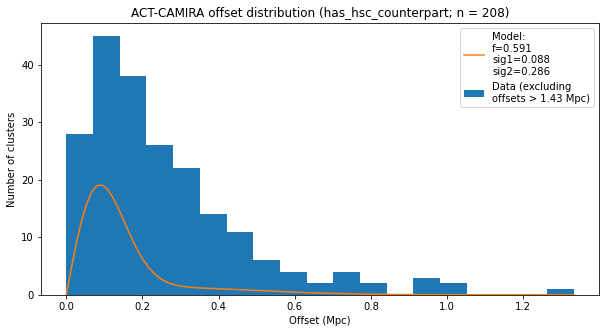

In [24]:
## Plot offset distribution (has_hsc_counterpart)

plt.figure(figsize=(10,5))
plt.title("ACT-CAMIRA offset distribution")

# Data
plt.title(f"ACT-CAMIRA offset distribution (has_hsc_counterpart; n = {len(offsets)})")
bins = np.linspace(0, np.max(offsets), num=20)
plt.hist(physical_sep, bins=bins, label=f"Data (excluding\noffsets > {np.round(limit,2)})")
plt.xlabel("Offset (Mpc)")
plt.ylabel("Number of clusters")

# Model
x_axis = np.linspace(0, np.max(offsets), num=100)
y_axis = offset_model(offset=x_axis, f_cen=f_best, sigma_1=sig1_best, sigma_2=sig2_best)
plt.plot(x_axis, y_axis, label=\
         f"Model:\nf={np.round(f_best,3)}\nsig1={np.round(sig1_best,3)}\nsig2={np.round(sig2_best,3)}")

plt.legend()
plt.show()

# Plot clusters on the sky

Reference: https://het.as.utexas.edu/HET/Software/Astropy-1.0/coordinates/skycoord.html#example-1-plotting-random-data-in-aitoff-projection

## Plot full catalogs

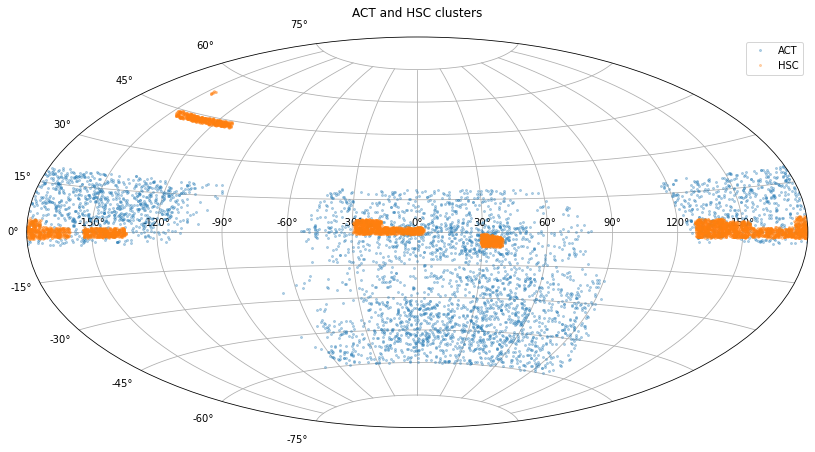

In [7]:
plt.figure(figsize=(14,9))

plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.plot(act_ra, act_dec, 'o', markersize=2, alpha=0.3, label='ACT')
plt.plot(hsc_ra, hsc_dec, 'o', markersize=2, alpha=0.3, label='HSC')

plt.title("ACT and HSC clusters", pad=20)
plt.legend()
plt.show()

## Plot a random subset of ACT clusters

(playing around with matplotlib)

In [1]:
# size = len(act_ra)
# rand_inds = np.random.uniform(size=size) > 0.98

# fig = plt.figure(figsize=(16,10))

# ax = plt.subplot(111, projection="aitoff")
# ax.set_facecolor('#C3FFFF')
# plt.grid(True)
# # unicode 00a9 = copyright symbol
# plt.plot(act_ra[rand_inds], act_dec[rand_inds], marker='$\u00A9$', 
#          markersize=20, linestyle='None', alpha=0.5, label='ACT', c='r')

# plt.title("Random ~2% of ACT galaxy clusters", pad=25)
# plt.show()

## Plot ACT clusters cross-matched with HSC, SDSS, and/or DES

Number of ACT clusters cross-matched with CAMIRA (HSC): 212
Number of ACT clusters cross-matched with redMaPPer (SDSS and/or DES): 2510
Number of ACT clusters cross-matched with at least one of the catalogs: 2600



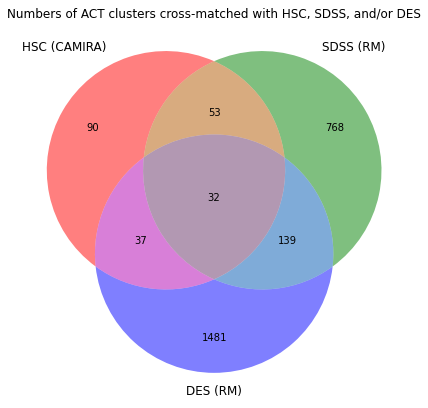

In [40]:
## Separate RM clusters based on if they have a counterpart:
# 1. only in one catalog,
# 2. in two catalogs, or 
# 3. in all three

has_hsc_counterpart = ACT_cat['CAMIRA']
has_sdss_counterpart = ACT_cat['RM'] 
has_des_counterpart = ACT_cat['RMDESY3']
print('Number of ACT clusters cross-matched with CAMIRA (HSC): ' + 
      str(np.sum(has_hsc_counterpart)))
print('Number of ACT clusters cross-matched with redMaPPer (SDSS and/or DES): ' + 
      str(np.sum(has_sdss_counterpart | has_des_counterpart)))
print('Number of ACT clusters cross-matched with at least one of the catalogs: ' + 
      str(np.sum(has_hsc_counterpart | has_sdss_counterpart | has_des_counterpart)))

print()

hsc_only = has_hsc_counterpart & (~has_sdss_counterpart) & (~has_des_counterpart)
sdss_only = (~has_hsc_counterpart) & has_sdss_counterpart & (~has_des_counterpart)
des_only = (~has_hsc_counterpart) & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss = has_hsc_counterpart & has_sdss_counterpart & (~has_des_counterpart)
sdss_des = (~has_hsc_counterpart) & has_sdss_counterpart & has_des_counterpart
hsc_des = has_hsc_counterpart & (~has_sdss_counterpart) & has_des_counterpart

hsc_sdss_des = has_hsc_counterpart & has_sdss_counterpart & has_des_counterpart

# 3-group Venn diagram showing #s of clusters in each category
from matplotlib_venn import venn3_unweighted

# order of subsets: A, B, AB, C, AC, BC, ABC
subsets = (np.sum(cam_only), np.sum(sdss_only), np.sum(cam_sdss), \
          np.sum(des_only), np.sum(cam_des), np.sum(sdss_des), \
          np.sum(cam_sdss_des))

plt.figure(figsize=(7,7))
plt.title("Numbers of ACT clusters cross-matched with HSC, SDSS, and/or DES")
venn3_unweighted(subsets = subsets, \
      set_labels = ('HSC (CAMIRA)', 'SDSS (RM)', 'DES (RM)'), \
      alpha = 0.5)

plt.show()

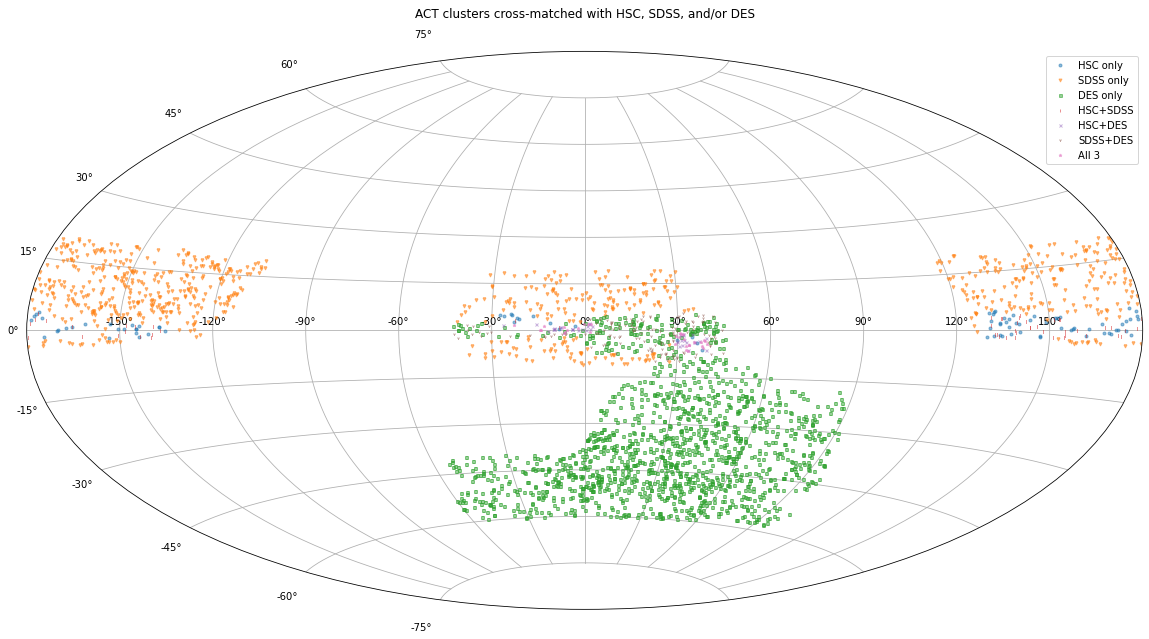

In [63]:
## Plot the different subsets

plt.figure(figsize=(20,13))

plt.subplot(111, projection="aitoff")
plt.grid(True)

plt.plot(act_ra[hsc_only], act_dec[hsc_only], 
         'o', markersize=3, alpha=0.5, label='HSC only')
plt.plot(act_ra[sdss_only], act_dec[sdss_only], 
         'v', markersize=3, alpha=0.5, label='SDSS only')
plt.plot(act_ra[des_only], act_dec[des_only], 
         's', markersize=3, alpha=0.5, label='DES only')

plt.plot(act_ra[hsc_sdss], act_dec[hsc_sdss], 
         '|', markersize=3, alpha=0.5, label='HSC+SDSS')
plt.plot(act_ra[hsc_des], act_dec[hsc_des], 
         'x', markersize=3, alpha=0.5, label='HSC+DES')
plt.plot(act_ra[sdss_des], act_dec[sdss_des], 
         '1', markersize=3, alpha=0.5, label='SDSS+DES')

plt.plot(act_ra[hsc_sdss_des], act_dec[hsc_sdss_des], 
         '*', markersize=3, alpha=0.5, label='All 3')

plt.title("ACT clusters cross-matched with HSC, SDSS, and/or DES", pad=40)
plt.legend()
plt.show()